# Electro-encephalogram simulation and analysis

Hugues Talbot, 17 December 2015

In this example we analyse a noisy signal. The objective is to be able to classify EEG-like patterns. Applications may include Brain-Computer Interfacing (BCI).

In [13]:
%matplotlib inline
# standard signal processing packages
import numpy as np
import scipy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
## learning    
from sklearn.svm import SVC

sampling = 20 # Sampling rate in Hz

## Signal production
Here we produce two different signal. They are fairly close to one another

In [37]:
# two signals
def f1(x):
    return np.sin(x)+ 0.5*np.cos(2*x) + 0.3*np.sin(4*x) + 0.2 * np.cos(8*x) 

def f2(x):
    return np.cos(1.1*x)+ 0.2*np.cos(2.5*x) + 0.6*np.sin(3.1*x) + 0.6 * np.cos(9.1*x)

## EEG-like output
In an EEG, the signal of interest is corrupted by noise and drift. The output of "simulate" will be used as a training pattern. In this signal, the first half is sig1, the second half is sig2.

In [38]:
## create some EEG-looking signal
def simulate(len=1024):
    x = np.arange(0,len,dtype=np.double) # 50s
    sig1 = f1(x/sampling)        
    sig2 = f2(x/sampling)

    # add drift and noise
    x2 = np.arange(0,2*len,dtype=np.double) # 50s
    sig = np.hstack((sig1,sig2)) + + 5*np.cos(0.1*x2/sampling) + 2*np.cos(0.25*x2/sampling)
    noise = np.random.normal(0,0.3,size=sig.size)
    mysig = sig+noise
    return mysig

## Test data
Here we produce some test data, which oscillate between sig1 and sig2, with a different corruption pattern.

In [39]:
# generate test data
def testdata(len=512):
    x = np.arange(0,len,dtype=np.double)
    sig1 = f2(x/sampling)
    sig2 = f1(x/sampling)
    sig3 = f2(x/sampling)
    sig4 = f1(x/sampling)
    x4 = np.arange(0,4*len,dtype=np.double) # 50s
    # different drift
    sig = np.hstack((sig1,sig2,sig3,sig4)) + + 4*np.sin(0.22*x4/sampling) + 2.3*np.cos(0.32*x4/sampling)
    noise = np.random.normal(0,0.6,size=sig.size) # twice as much noise
    testsig = sig+noise
    return testsig

## Spectrogram
This function output the spectrogram of a signal. This correspond to a time-dependent FFT analysis of the signal. In the parameters, NFFT is the length of the FFT, and overlap is the amount by which subsequent FFTs overlap each other.

In [72]:
def spectrog(mysig):
    Pxx, freqs, t, im = plt.specgram(mysig,NFFT=128,noverlap=64,Fs=sampling)              
    return Pxx

## Main
Here we begin the production and analysis of our signal.

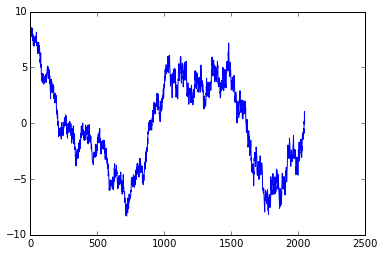

In [73]:
s = simulate()
plt.plot(s)

In the plot above, it is not obvious that it is composed of two types of signals. For this we look at its spectrogram, i.e. it spectrum over time.

There are 31 spectra, each 65 long


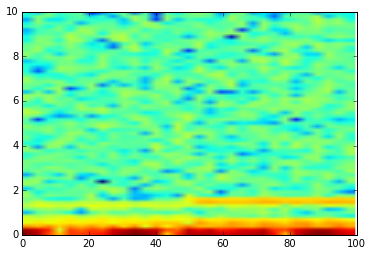

In [74]:
## spectrogram
plt.figure()
analysis = spectrog(s)
# Analysis contains the spectra. 
# There are s.size/(NFFT-noverlap) - 1 spectra
# The spectra are NFFT/2+1 long
analysis.shape
print("There are %d spectra, each %d long" % (analysis.shape[1], analysis.shape[0]))

In the spectrogram above we, wee see that indeed the first half is different from the second half, see for example the orange line in the second half near a value of 2. Let us look at some of the frequencies over time.

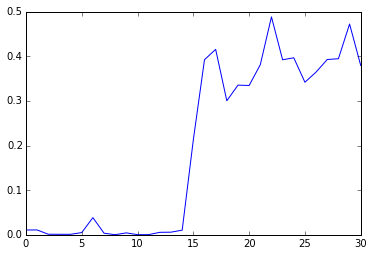

In [105]:
## one frequency
plt.figure()
# we wee that there is enough data in the spectra to distinguish 
# sig1 from sig2
# eg. one descriptor
plt.plot(analysis[10,:])

Just by using this single frequency, we should be able to distinguish sig1 from sig2. Using a few more frequencies should help us even more.

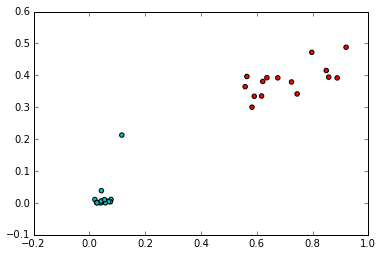

In [96]:
## example features
plt.figure()
NS = analysis.shape[1] # number of spectra
# color vector
# make sure the vector has the correct length
if (NS %2 == 0):    
    cols = 'c'*(NS/2) + 'r'*(NS/2)
    y = np.hstack((np.zeros(NS/2),np.ones(NS/2)))
else:
    cols = 'c'*(NS/2+1) + 'r'*(NS/2)
    y = np.hstack((np.zeros(NS/2+1),np.ones(NS/2)))
# all the cyans near zero
plt.scatter(analysis[9,:], analysis[10,:],c=cols) # features around 9-10 seem to do the job

## Variable selection
In this plot, the green dots are the points data points from the first half of the signal, and the red dots those from the second half. We see that there is a relatively clear distinction between them. Now we use machine learning to draw a distinction between these signals automatically.

## Machine learning
Here we will select a subset of the useful spectral frequencies and fit a Support Vector Machine. An SVM is an advanced classifying technique. Here we are using it in its default, linear setting. A linear SVM attempts to draw a separating hyperplan between descriptors. As descriptors we will use the frequencies selected above. 

In [98]:
# spectra elements are now features, X shape should be
# X.shape = (nb_features, nb_samples)
# y is the ground truth
# y.shape should be (nb_samples,)
X = analysis[8:12,:].T # we only use as subset of the features

    
clf = SVC() # classifier
clf.fit(X, y) # train on first signal

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Test data
Here we generate some test data and check that our classifier works.

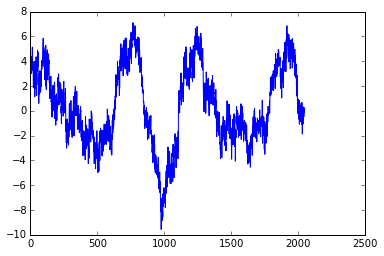

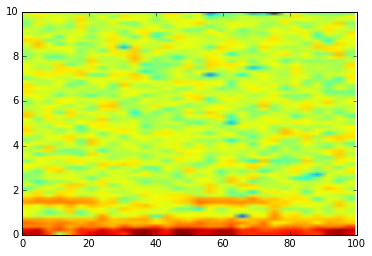

In [99]:
tst = testdata()
plt.figure()
plt.plot(tst)    
plt.figure()
tstanalysis = spectrog(tst)

The spectrogram of this signal is different but 

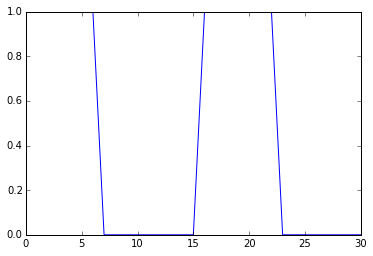

In [101]:
# the real McCoy
result = clf.predict(tstanalysis[8:12].T)
plt.plot(result) # prefect result

Perfect result. However this was a relatively easy problem. Now we need to try on a real EEG example. Remember the list of important steps 

- Data analysis : here the spectrogram
- Variable selection : can a subset of the variables be used to characterize the important parts of the signal, here we selected the variable by hand, but a PCA could also be most useful.
- Training data : we need *annotated* data, i.e. a ground truth, here provided with the first signal
- A good classifier : here we used an SVM
- Test data.
